$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 6: Neural Networks

Nathan Kluth

## Overview

In this document, you will find code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below. There is one example using a regression problem, and one using a classification problem.

In [1]:
## Brought in from outisde file
import neuralnetworks as nns
import scaledconjugategradient as scg
import mlutils as ml
import numpy as np

## Required Code

First up `trainNNs`. 

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 
* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure

In [2]:
import time

def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    results = []
    t0 = time.time()

    for layer in hiddenLayerStructures:
        trainDataPerf = []
        testDataPerf = []
        
        for rep in range(numberRepetitions):
            # partition data set into train/test
            Xtrain,Ttrain,Xtest,Ttest = ml.partition(X, T, (trainFraction, 1-trainFraction), classify);

            # create a neural network of the given structure
            nnet = nns.NeuralNetwork(Xtrain.shape[1], layer, Ttrain.shape[1]);

            # train it for numberIterations
            nnet.train(Xtrain, Ttrain, numberIterations)

            # use the trained network to produce outputs for the training and for the testing sets
            Y = nnet.use(Xtrain)
            Ytest, _ = nnet.use(Xtest, allOutputs=True)

            trainingResult = None
            testingResult = None
            if (classify):
                # calculate the fraction of samples incorrectly classififed for training and testing sets. 
                values,counts = np.unique(Ttrain, return_counts=True)
                values2,counts2 = np.unique(Ttest, return_counts=True)
                
                trainingResult = (counts / Ttrain.shape[0]).tolist()
                testingResult = (counts2 / Ttest.shape[0]).tolist()
                
                # add the training and testing preformance to a collection (such as a list) for this network structure
                trainDataPerf = trainDataPerf + trainingResult
                testDataPerf = testDataPerf + testingResult
            else:
                # calculate RMSE of trainng and testing sets
                trainingResult = np.sqrt(np.mean((Y-Ttrain)**2))
                testingResult = np.sqrt(np.mean((Ytest-Ttest)**2))
                
                # add the training and testing preformance to a collection (such as a list) for this network structure
                trainDataPerf = trainDataPerf + [trainingResult]
                testDataPerf = testDataPerf + [testingResult]
            
        # add to a collection iof all results the hidden layer structure, 
        # lists of training performance and testing performance, and seconds taken to do these repeitions
        results += [[layer, trainDataPerf, testDataPerf, time.time() - t0]]
    return results

Here are a few helper functions for taking a look at the results:

`summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean. 

`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

In [3]:
import copy as cp

def summarize(results): 
    summary = cp.deepcopy(results)
    
    for summ in summary:
        summ[1] = float(sum(summ[1])) / len(summ[1])
        summ[2] = float(sum(summ[2])) / len(summ[2])
    return summary

In [4]:
summary = summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

In [5]:
def bestNetwork(summary):
    best = float('inf')
    bestIndex = -1
    for (index, network) in enumerate(summary):
        if (network[2] < best):
            best = network[2]
            bestIndex = index
            
    return summary[bestIndex]

In [6]:
bestNetwork(summary)

[[1, 1], 1.3, 2.3000000000000003, 0.5]

## Examples


In [7]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

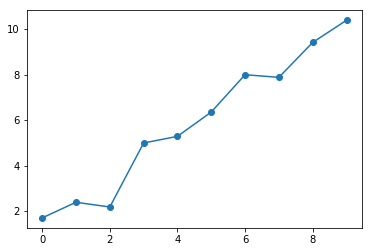

In [9]:
plt.plot(X, T, 'o-');

In [10]:
nnet = nns.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([ 0.70710678,  0.28408674,  0.16213987,  0.1621314 ,  0.12025594,
        0.11984705,  0.11889843,  0.11883879,  0.11878718,  0.11878088,
        0.11878088,  0.11827175,  0.11816814,  0.11808812,  0.11804607,
        0.1180408 ,  0.11803604,  0.11786684,  0.11786531,  0.11761915,
        0.11761754,  0.1175882 ,  0.11756965,  0.11756856,  0.11756829,
        0.11755689,  0.11755687,  0.11755675,  0.11755588,  0.11755585,
        0.11755583,  0.11755566,  0.1175556 ,  0.11755559,  0.11755558,
        0.11755558,  0.11755556,  0.11755556,  0.11755556,  0.11755554,
        0.11755553,  0.11755552,  0.11755552,  0.11755534,  0.11755525,
        0.11755524,  0.11755522,  0.11755522,  0.11755522,  0.11755519,
        0.11755519,  0.11755519,  0.11755516,  0.11755516,  0.11755516,
        0.11755515,  0.11755515,  0.11755515,  0.11755515,  0.11755515,
        0.11755514,  0.11755514,  0.11755514,  0.11755514,  0.11755511,
        0.11755511,  0.11755511,  0.11755508,  0.11755508,  0.11

In [11]:
nnet = nns.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([ 0.70710678,  0.57180063,  0.57180063,  0.46210517,  0.31659347,
        0.24528895,  0.14880738,  0.13694919,  0.13204544,  0.12569857,
        0.11649055,  0.11590391,  0.11569306,  0.11566122,  0.11562937,
        0.11551468,  0.11505223,  0.11464121,  0.11449277,  0.11437105,
        0.11413091,  0.11391687,  0.11387749,  0.11384074,  0.11380551,
        0.11366933,  0.11363948,  0.11341866,  0.11295234,  0.11281427,
        0.1121272 ,  0.10893423,  0.10890256,  0.10874585,  0.10801654,
        0.1071216 ,  0.10579049,  0.10578391,  0.10575908,  0.10516641,
        0.10508071,  0.10488666,  0.10478763,  0.10472251,  0.1046463 ,
        0.10464091,  0.10460702,  0.10459603,  0.10457686,  0.10449735,
        0.10442185,  0.10423975,  0.10418259,  0.10412981,  0.1038987 ,
        0.10315412,  0.1030837 ,  0.1029208 ,  0.10291564,  0.10270774,
        0.10265041,  0.10264459,  0.10262698,  0.10249307,  0.10248554,
        0.102406  ,  0.10237379,  0.10222272,  0.10211548,  0.10

In [12]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.32559415354725746,
   0.35128734805052325,
   0.42726251359300305,
   0.37796141482226986,
   0.30200554616264091],
  [1.0610948863220153,
   0.81362166868474495,
   0.82828168910198607,
   0.46679577714257336,
   1.1479178534834495],
  0.1255168914794922],
 [10,
  [0.30879085833882286,
   0.25304698956899441,
   0.30236597426110412,
   0.23314699373240921,
   0.18618393189099372],
  [1.2920149331307409,
   0.82968556570037844,
   1.2311098851960414,
   0.83273766166494945,
   1.3759975702312004],
  0.23699688911437988],
 [[10, 10],
  [0.12138377372434454,
   0.23165055934117645,
   0.14832568538559424,
   0.25451380023971698,
   0.25917083459781282],
  [2.5406995061033681,
   1.0816817957414753,
   1.4484837337617731,
   0.9951388738587108,
   0.89465270687672172],
  0.390239953994751]]

In [13]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 400, classify=False)

In [14]:
summarize(results)

[[0, 0.4653129554439147, 0.5624970085904204, 0.024330854415893555],
 [1, 0.4387512270634915, 0.7247390318095657, 1.6899747848510742],
 [2, 0.29426209670360354, 1.2917976612313558, 6.086277961730957],
 [10, 0.02932988379688262, 1.6148491361698531, 9.61492109298706],
 [[10, 10], 0.018694059140247302, 1.6187905412919559, 15.430840969085693],
 [[5, 5, 5, 5], 0.13498450919911772, 1.2277986716140572, 24.376418828964233],
 [[2, 2, 2, 2, 2], 0.29428828253752715, 1.340021719418809, 33.97822403907776]]

In [15]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.4653129554439147, 0.5624970085904204, 0.024330854415893555]
Hidden Layers 0 Average RMSE Training 0.47 Testing 0.56 Took 0.02 seconds


## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.



In [16]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

In [17]:
import csv

def readEnergyFile(fileName):
    file = open(fileName, 'r')
    formatted = file.read().strip().replace('"','')
    newFile = open('newfile.csv','w') 
    newFile.write(formatted)
    
    readFormatted = open('newfile.csv', 'r')
    header = readFormatted.readline()
    fullNames = header.strip().replace('"', '').split(',')
    names = fullNames[1:len(fullNames)-2]

    data = np.loadtxt(readFormatted, delimiter=',', usecols=1+np.arange(26))
    return (names, data)

In [18]:
names, data = readEnergyFile("energydata_complete.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'energydata_complete.csv'

In [ ]:
names

In [ ]:
data.shape

In [ ]:
data[:2,:]

I will use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So:

In [ ]:
import copy as cp

targetColumn = names.index("Appliances")
targetColumn2 = names.index("lights")
XColumns = np.arange(26)
XColumns = np.delete(XColumns, targetColumn)
XColumns = np.delete(XColumns, targetColumn2)

Tenergy = data[:, [targetColumn, targetColumn2]] #.reshape((-1, 1)) # to keep 2-d matrix form
Xenergy = data[:, XColumns]

Xnames = cp.deepcopy(names)
Xnames.remove('Appliances')
Xnames.remove('lights')

Tnames = ['Appliances', 'lights']

In [ ]:
Xenergy.shape, Tenergy.shape

In [ ]:
Xnames

In [ ]:
Tnames

Now, I'm going to train a bunch of networks and see which is best so I can use that to train the Neural Network!

In [ ]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [ ]:
summarize(results)

In [ ]:
bestNetwork(summarize(results))

In [ ]:
results2 = trainNNs(Xenergy, Tenergy, 0.8, [1, 5, [5, 5], 10, [3, 3, 3], [8, 8], 15, [2, 2, 2, 2], [10, 10], [5, 5, 5]], 10, 100)

In [ ]:
summarize(results2)

In [ ]:
bestNetwork(summarize(results2))

Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

I *think* is has to do with the small amount of training data - it isn't enough to characterize the test data sufficiently.

In [ ]:
BXtrain,BTtrain,BXtest,BTtest = ml.partition(Xenergy, Tenergy, (0.8, 0.2), classification=False);
Bestnnet = nns.NeuralNetwork(BXtrain.shape[1], 10, BTtrain.shape[1]); # again using best network
Bestnnet.train(BXtrain, BTtrain, 100)

Ptrain,Prtrain = Bestnnet.use(BXtrain,allOutputs=True)
Ptest,Prtest = Bestnnet.use(BXtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((BTtrain,Ptrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((BTtest,Ptest)), '.')
plt.legend(('Actual','Predicted'));

I'm not sure where the green comes from

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.

In [20]:
# !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
# !unzip Anuran*zip

ERROR:root:Line magic function `%!wget` not found.
ERROR:root:Line magic function `%!unzip` not found.


In [23]:
import csv

def noop(string):
    return 0; # do nothing 

def convertSpecies(string, species):
    """ check the passed in dictionary for the value and return it if it exists
    otherwise, create a new entry """
    if string in species:
        return species[string];
    
    if string not in species:
        species[string] = len(species)
        return len(species)

def readAnuranFile(fileName):
    species = {}
    file = open(fileName,"r")
    header = file.readline()
    names = header.strip().split(',')

    data = np.loadtxt(file ,delimiter=',', usecols=1+np.arange(25), converters={
        24: lambda s: convertSpecies(s, species),
        23: lambda s: noop(s),
        22: lambda s: noop(s)
    })
    return (names, data)

In [24]:
Anames, Adata = readAnuranFile("Frogs_MFCCs.csv")
Anames, Adata

(['MFCCs_ 1',
  'MFCCs_ 2',
  'MFCCs_ 3',
  'MFCCs_ 4',
  'MFCCs_ 5',
  'MFCCs_ 6',
  'MFCCs_ 7',
  'MFCCs_ 8',
  'MFCCs_ 9',
  'MFCCs_10',
  'MFCCs_11',
  'MFCCs_12',
  'MFCCs_13',
  'MFCCs_14',
  'MFCCs_15',
  'MFCCs_16',
  'MFCCs_17',
  'MFCCs_18',
  'MFCCs_19',
  'MFCCs_20',
  'MFCCs_21',
  'MFCCs_22',
  'Family',
  'Genus',
  'Species',
  'RecordID'],
 array([[  1.52936298e-01,  -1.05585903e-01,   2.00721915e-01, ...,
           0.00000000e+00,   1.00000000e+00,   1.00000000e+00],
        [  1.71534257e-01,  -9.89747371e-02,   2.68425221e-01, ...,
           0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
        [  1.52317085e-01,  -8.29726739e-02,   2.87127957e-01, ...,
           0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
        ..., 
        [ -5.82556781e-01,  -3.43237394e-01,   2.94678468e-02, ...,
           0.00000000e+00,   9.00000000e+00,   6.00000000e+01],
        [ -5.19497158e-01,  -3.07553060e-01,  -4.92150002e-03, ...,
           0.00000000e+00,   9.

In [25]:
import copy as cp

AXColumns = np.arange(26)

AtargetColumn4 = Anames.index('RecordID')
AXColumns = np.delete(AXColumns, AtargetColumn4)

AtargetColumn = Anames.index("Species")
AXColumns = np.delete(AXColumns, AtargetColumn)

AtargetColumn3 = Anames.index('Genus')
AXColumns = np.delete(AXColumns, AtargetColumn3)

AtargetColumn2 = Anames.index('Family')
AXColumns = np.delete(AXColumns, AtargetColumn2)

Tanuran = Adata[:, [AtargetColumn, AtargetColumn2, AtargetColumn3]].reshape((-1, 1)) # to keep 2-d matrix form
Xanuran = Adata[:, AXColumns]

AXnames = cp.deepcopy(Anames)
AXnames.remove('Species')
AXnames.remove('Family')
AXnames.remove('Genus')
AXnames.remove('RecordID')

ATnames = ['Species']

In [26]:
Xanuran.shape, Tanuran.shape

((7195, 22), (21585, 1))

In [27]:
Xanuran[:2,:]

array([[ 0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,  0.26076385,
         0.10094464, -0.1500626 , -0.17112763,  0.12467644,  0.18865415,
        -0.07562172, -0.15643593,  0.08224512,  0.13575204, -0.02401665,
        -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,  0.11868014,
         0.01403845,  0.        ],
       [ 0.17153426, -0.09897474,  0.26842522,  0.33867186,  0.2683531 ,
         0.06083509, -0.22247464, -0.20769267,  0.17088287,  0.27095828,
        -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,  0.01202228,
        -0.09097401, -0.05650952, -0.03530336,  0.02013996,  0.08226299,
         0.02905574,  0.        ]])

In [28]:
Tanuran[:2]

array([[ 1.],
       [ 0.]])

In [29]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

7866 samples in class 0
594 samples in class 1
3532 samples in class 2
332 samples in class 3
560 samples in class 4
1145 samples in class 5
313 samples in class 6
131 samples in class 7
440 samples in class 8
216 samples in class 9


In [30]:
results3 = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [31]:
results3

[[0,
  [0.42665971498088284,
   0.08255126868265554,
   0.17205422314911367,
   0.0031282586027111575,
   0.012165450121654502,
   0.0033020507473062216,
   0.005908932916232186,
   0.0024330900243309003,
   0.05179005908932916,
   0.009384775808133473,
   0.01338199513381995,
   0.021897810218978103,
   0.007994438651372959,
   0.02259297879735836,
   0.027632950990615225,
   0.062391379909628085,
   0.012165450121654502,
   0.019117135905457074,
   0.04344803614876608,
   0.42665971498088284,
   0.08255126868265554,
   0.17205422314911367,
   0.0031282586027111575,
   0.012165450121654502,
   0.0033020507473062216,
   0.005908932916232186,
   0.0024330900243309003,
   0.05179005908932916,
   0.009384775808133473,
   0.01338199513381995,
   0.021897810218978103,
   0.007994438651372959,
   0.02259297879735836,
   0.027632950990615225,
   0.062391379909628085,
   0.012165450121654502,
   0.019117135905457074,
   0.04344803614876608,
   0.42665971498088284,
   0.08255126868265554,
   0.

In [32]:
summarize(results3)

[[0, 0.05263157894736842, 0.05263157894736842, 0.2121257781982422],
 [5, 0.05263157894736842, 0.05263157894736842, 1.9051449298858643],
 [[5, 5], 0.05263157894736842, 0.05263157894736842, 4.404841899871826]]

In [33]:
bestNetwork(summarize(results3))

[0, 0.05263157894736842, 0.05263157894736842, 0.2121257781982422]

In [34]:
results4 = trainNNs(Xanuran, Tanuran, 0.8, [1, 5, [5, 5], 10, [3, 3, 3], [8, 8], 15, [2, 2, 2, 2], [10, 10], [5, 5, 5]], 10, 100, classify=True)

In [35]:
bestNetwork(summarize(results4))

[1, 0.05263157894736841, 0.052631578947368404, 1.6099069118499756]

In [ ]:
AXtrain,ATtrain,AXtest,ATtest = ml.partition(Xanuran, Tanuran, (0.8, 0.2), classification=True);
AnBestnnet = nns.NeuralNetwork(AXtrain.shape[1], 1, ATtrain.shape[1]); # again using best network
AnBestnnet.train(AXtrain, ATtrain, 100)

APtrain,APrtrain = AnBestnnet.use(AXtrain,allOutputs=True)
APtest,APrtest = AnBestnnet.use(AXtest,allOutputs=True)
plt.subplot(2,1,1)
plt.plot(np.hstack((ATtrain,APtrain)), '.')
plt.legend(('Actual','Predicted'))
plt.subplot(2,1,2)
plt.plot(np.hstack((ATtest,APtest)), '.')
plt.legend(('Actual','Predicted'));

Looking at the graph - I'm not really sure what is going on. it looks like after a certain amount of time the actual values go off the rails a bit. 